In [14]:
from itertools import product, filterfalse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Import original dataset
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
)
data_len = {'train': len(train_data), 'test': len(test_data)}
print(data_len)

{'train': 60000, 'test': 10000}


## Set up functions and parameters

In [98]:
# ARBITRARY PARAMS
# Velocity of medium
v_m = 1
# Velocity of source
# positive if moving away from observer
v_s = 0
# Assumed source frequency
f_s_0 = 0.6
# Distance of observer to pos 0 (on 3rd axis)
l_0 = 1
# Distance between neighboring positions
# Decrease l_x to increase effect of neighbors (l_x -> 0 means v_x -> v_0)
l_x = 0.01

In [4]:
# Input: Observed frequency of pos 0 (positive if moving towards source)
def calcVelocity(f_o_0):
    v_0 = (v_m + v_s) / f_s_0 * f_o_0 - v_m
    return v_0

# Input: Two positions of a 2d array
# Returns: Their distance, assuming that neighboring positions have distance l_x
def calcDist(pos1, pos2):
    return l_x * np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Input: Observer velocity, observed frequency of neighbor pos, distance of neighbor pos
# Returns: source frequency of neighbor (doppler effect using observer velocity relative to neighbor in 3rd axis)
def applyVelocity(v_0, f_o_x, dist):
    v_x = v_0 * l_0 / np.sqrt(dist**2 + l_0**2)
    f_s_x = f_o_x * (v_m + v_s) / (v_m + v_x)
    return f_s_x

## Apply symbol dynamics to images

In [94]:
def dynamics_iteration(img):
    new_img = np.zeros_like(img)
    img_positions = [(x, y) for x in range(img.shape[0]) for y in range(img.shape[1])]
    for pos_0 in img_positions:  # reference position
        v_0 = calcVelocity(img[pos_0])
        for pos_x in filterfalse(lambda pos_x: pos_x == pos_0, img_positions):  # all other positions
            dist = calcDist(pos_0, pos_x)
            new_img[pos_x] += applyVelocity(v_0, img[pos_x], dist)
    new_img = new_img / (img.size - 1)  # Average -- ???
    new_img = new_img / new_img.max()  # keep values between 0 and 1
    return new_img

def image_dynamics(img, iters):
    working_img = np.copy(img)
    working_img += 0.1  # avoid 0s
    working_img = working_img / working_img.max()
    for i in range(iters):
        working_img = dynamics_iteration(working_img)

    # print(working_img - img)
    return working_img

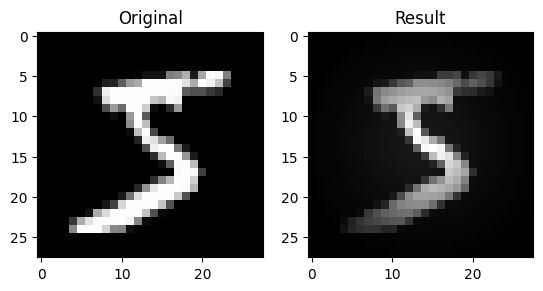

In [99]:
iters = 5

img = train_data[0][0][0].numpy()
result = image_dynamics(img, iters)

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Original")
axs[1].set_title("Result")
axs[0].imshow(img, cmap='gray')
axs[1].imshow(result, cmap='gray')